In [29]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import GPyOpt
from torch.autograd import Variable

In [30]:
def normalize(data, norm_type):
    if norm_type == "minmax":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].min()) / (data[:,i].max()-data[:,i].min())
        return data
    elif norm_type == "zscore":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].mean()) / (data[:,i].std())
        return data
    elif norm_type == None:
        return data
    else:
        raise ValueError("Please choose a correct normalization type")
#Xnumtrain = torch.tensor(np.vstack([(Xnumtrain[:,i]-Xnumtrain[:,i].min()) / (Xnumtrain[:,i].max()-Xnumtrain[:,i].min()) for i in range(Xnumtrain.size()[1]) if "Tue elsker det her"])).view(-1,2)

def dataprep(data, norm_type = "zscore"):
    for category in categoricals:
        data[category] = data[category].astype("category")

    catdata = []
    for i in range(len(categoricals)):
        catdata.append(data[categoricals[i]].cat.codes.values)
    catdata = torch.tensor(catdata, dtype = torch.int64).T
    
    
    numdata = np.stack([data[col].values for col in numericals], 1)
    numdata = torch.tensor(numdata, dtype=torch.float)

    normalize(numdata, norm_type)
    return catdata, numdata

def permutation(data, cat):
    perm_data = data.copy()
    rand_num = np.random.randint(0 , len(data[cat]) , len(data[cat]))
    perm_data[cat][np.arange(len(data[cat]))] = data[cat][rand_num] 
    df = perm_data
    return df

def reset_data():
    return pd.read_csv("https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv")

# Data Visualization and Pre-processing

In [31]:
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv"
data = pd.read_csv(url)

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
#print(data.columns)

No GPU available.


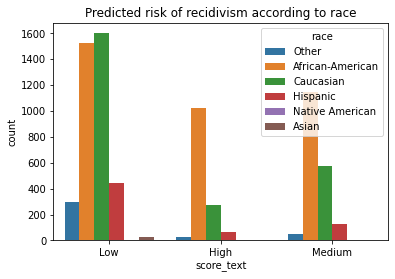

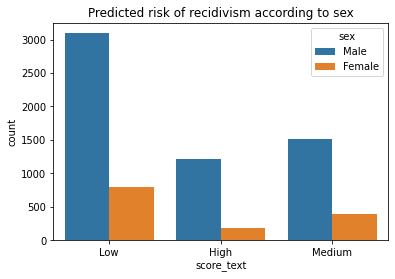

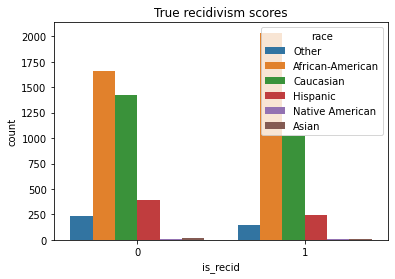

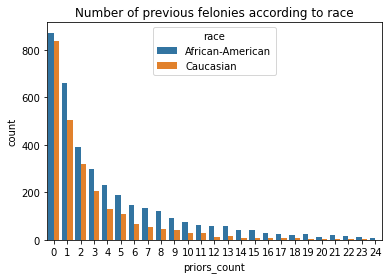

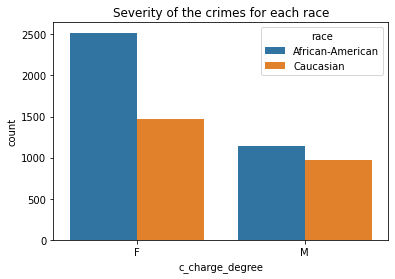

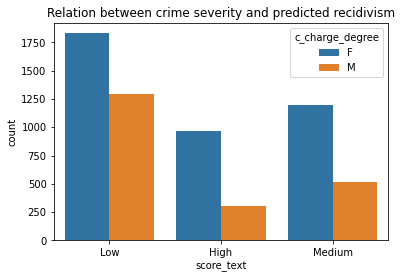

100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


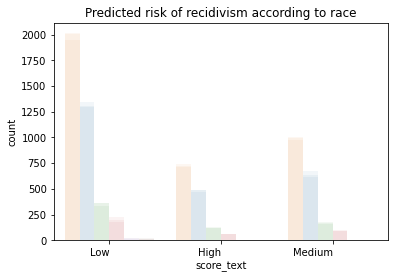

In [32]:
def is_plot():
    
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    
    pred_plot_race = sb.countplot(x = "score_text", hue = "race", data = data)
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    pred_plot_race.figure.savefig(path + "\\predicted_recid_race.png")
    plt.show()
    
    pred_plot_sex = sb.countplot(x = "score_text", hue = "sex", data = data)
    pred_plot_sex.set_title("Predicted risk of recidivism according to sex")
    pred_plot_sex.figure.savefig(path + "\\predicted_recid_sex.png")
    plt.show()
    
    true_plot = sb.countplot(x = "is_recid", hue = "race", data = data)
    true_plot.set_title("True recidivism scores")
    true_plot.figure.savefig(path + "\\true_recid.png")
    plt.show()
    
    df = data[(data["race"] == "African-American") | (data["race"] == "Caucasian")]
    df = df[df["priors_count"] < 25]
    
    priors_plot = sb.countplot(x = "priors_count", hue = "race", data = df)
    priors_plot.set_title("Number of previous felonies according to race")
    priors_plot.figure.savefig(path + "\\proirs.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "c_charge_degree", hue = "race", data = df)
    c_charge_degree.set_title("Severity of the crimes for each race")
    c_charge_degree.figure.savefig(path + "\\c_charge_degree.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "score_text", hue = "c_charge_degree", data = df)
    c_charge_degree.set_title("Relation between crime severity and predicted recidivism")
    c_charge_degree.figure.savefig(path + "\\charge_degree_score.png")
    plt.show()
    
    
is_plot()

palette = {"Caucasian": "C0", "African-American": "C1", "Hispanic": "C2", "Other": "C3" , "Asian": "C4" ,"Native American": "C5"}
for i in tqdm(range(3)):
    #TODO: der skal indsættes punkter for den rigtige data1fordelling. 
    data = permutation(data, "race")
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    pred_plot_race = sb.countplot(x = "score_text" ,hue = "race", data = data, palette = palette ,alpha=.06,  hue_order = [ "African-American","Caucasian", "Hispanic", "Other" , "Asian","Native American"])
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    pred_plot_race.set_xticklabels(pred_plot_race.get_xticklabels(), horizontalalignment ='right')
    pred_plot_race.get_legend().remove()
    data = reset_data()
plt.show()
    


In [33]:
categoricals = ["c_charge_degree", "race", "age_cat", "sex"] # "r_charge_degree"    "two_year_recid"    "is_recid", "is_violent_recid"
numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"] # "days_b_screening_arrest"
outputs = ["score_text"]
data = data[categoricals + numericals + outputs + ["two_year_recid"]]

# Making the output binary
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',1)
data[outputs] = data[outputs].astype("category")

In [34]:
Xcat, Xnum = dataprep(data, norm_type = "zscore")

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = y[totalnumber - testnumber:totalnumber]


# Make sure that we dont validate on training data to compare if the algorithm is biased


normalize(Xnumtrain, "zscore");
normalize(Xnumtest, "zscore");

# Neural Network

In [35]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return nn.functional.sigmoid(x)

# Train model on data

In [68]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True


Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(6, 3)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64

In [69]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5

In [73]:

def train_model(hyperparameters, model, epochs = 100, plot = False):
    in_features, out_features = 11, 1
    p = hyperparameters['p']
    hidden_units_1 = hyperparameters['hidden_units_1']
    hidden_units_2 = hyperparameters['hidden_units_2']
    hidden_units_3 = hyperparameters['hidden_units_3']
    hidden_units_4 = hyperparameters['hidden_units_4']
    hidden_units_5 = hyperparameters['hidden_units_5']
    activation_func = hyperparameters['activation_func']
    
    model.layers[0] = torch.nn.Linear(in_features, hidden_units_1) 
    model.layers[1] = activation_func
    model.layers[2] = torch.nn.BatchNorm1d(hidden_units_1)
    model.layers[3] = torch.nn.Dropout(p=p)
    model.layers[4] = torch.nn.Linear(hidden_units_1, hidden_units_2) 
    model.layers[5] = activation_func
    model.layers[6] = torch.nn.BatchNorm1d(hidden_units_2)
    model.layers[7] = torch.nn.Dropout(p=p)
    model.layers[8] = torch.nn.Linear(hidden_units_2, hidden_units_3) 
    model.layers[9] = activation_func
    model.layers[10] = torch.nn.BatchNorm1d(hidden_units_3)
    model.layers[11] = torch.nn.Dropout(p=p)
    model.layers[12] = torch.nn.Linear(hidden_units_3, hidden_units_4) 
    model.layers[13] = activation_func
    model.layers[14] = torch.nn.BatchNorm1d(hidden_units_4)
    model.layers[15] = torch.nn.Dropout(p=p)
    model.layers[16] = torch.nn.Linear(hidden_units_4, hidden_units_5) 
    model.layers[17] = activation_func
    model.layers[18] = torch.nn.BatchNorm1d(hidden_units_5)
    model.layers[19] = torch.nn.Dropout(p=p)
    model.layers[20] = torch.nn.Linear(hidden_units_5, out_features) 
    
    aggregated_losses = []
    
    # Initialize lists for training and validation
    train_iter = []
    train_loss, train_accs = [], []
    valid_iter = []
    valid_loss, valid_accs = [], []

    model.train()
    for i in range(epochs):
        i += 1
        y_pred = model(Xcattrain, Xnumtrain)
        single_loss = loss_function(y_pred, ytrain.float())
        aggregated_losses.append(single_loss)

        #if i % 25 == 1:
            #print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


    
    # Plot the loss over epocs
    if plot:
        plt.plot(range(epochs), aggregated_losses)
        plt.ylabel('Loss')
        plt.xlabel('epoch');


    # Predict on the test set
    model.eval()
    with torch.no_grad():
        y_val = model(Xcattest, Xnumtest)
        loss = loss_function(y_val, ytest.float())


    y_val = (y_val > threshold).float()

    
    #print(confusion_matrix(ytest,y_val))
    #print(classification_report(ytest,y_val))
    neural_acc = accuracy_score(ytest, y_val)
    
    return model, float(neural_acc)

# Random Forest

In [50]:
# Define the model and fit it to the data
def RandomForest(datatrain, datatest, ytrain, ytest, n_estimators = 53, max_depth = 14, max_features = "log2", criterion = "entropy", show_acc = True):
    forestModel = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features, criterion = criterion)
    forestModel.fit(datatrain, ytrain)

    # Predict on the test set
    forestPreds = forestModel.predict(datatest)

    forestProbs = forestModel.predict_proba(datatest)[:, 1]

    if show_acc:
        print("Predicted no recidivism: ", len(forestPreds[forestPreds == 0]))
        print("Predicted recidivism: ", len(forestPreds[forestPreds == 1]))

        print("Accuracy of the random forest model: ", len(forestPreds[torch.tensor(forestPreds, dtype = torch.int64) == ytest]) / len(forestPreds))

RandomForest(Xcattrain, Xcattest, ytrain, ytest, n_estimators = 53, max_depth = 14, max_features = "log2", criterion = "entropy", show_acc = True)

Predicted no recidivism:  696
Predicted recidivism:  746
Accuracy of the random forest model:  0.6615811373092927


# Baysian Optimization

In [75]:
ACTIV = {0: torch.nn.Tanh(),
         1: torch.nn.ReLU(),
         2: torch.nn.ReLU6(),
         3: torch.nn.Sigmoid(),
        }

netsize = 246

## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    hyperparameters = {
        'hidden_units_1': int(np.ceil(param[0]*netsize*0.4)+int(10)),
        'hidden_units_2': int(np.ceil(param[0]*netsize*0.7)+int(10)),
        'hidden_units_3': int(np.ceil(param[0]*netsize)+int(10)),
        'hidden_units_4': int(np.ceil(param[0]*netsize*0.7)+int(10)),
        'hidden_units_5': int(np.ceil(param[0]*netsize*0.4)+int(10)),
        'p': param[1],
        'activation_func': ACTIV[int(param[2])]
    }
    print(hyperparameters)
    trained_model, neural_acc  = train_model(hyperparameters, model)
    print(neural_acc)
    return -neural_acc
    
# define the dictionary for GPyOpt
domain = [{'hidden_units'   : 'var_1', 'type': 'continuous', 'domain': (0 , 1)},
          {'p'              : 'var_2', 'type': 'continuous',  'domain': (0 , 1)},
          {'activation_func': 'var_3', 'type': 'categorical','domain': tuple(np.arange(4))}]


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 100) 


x_best = opt.X[np.argmin(opt.Y)]
print("bedste: ", x_best)
#print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
#    x_best[2])  + ", criterion=" + str(
#    x_best[3]))

[[0.18324657 0.35864465 0.97407988 0.97822953 0.58918908 0.01814298
  3.        ]]
{'hidden_units_1': 56, 'hidden_units_2': 99, 'hidden_units_3': 250, 'hidden_units_4': 251, 'hidden_units_5': 155, 'p': 0.018142981724827645, 'activation_func': Sigmoid()}


KeyboardInterrupt: 

# Baseline

In [ ]:

def baseline(data):
    if len(data[data["score_text"] == 0]) > len(data[data["score_text"] == 1]):
        y_pred = [0] * len(data["score_text"])
        y_pred = torch.tensor(y_pred)
    else:
        y_pred = [1] * len(data["score_text"])
        y_pred = torch.tensor(y_pred)
    return y_pred

trues = torch.tensor(data["score_text"])
y_pred = baseline(data)
conf_baseline = confusion_matrix(y_pred,trues)
print(conf_baseline)
print(conf_baseline / conf_baseline.astype(np.float).sum())
baseline_acc = accuracy_score(y_pred, trues)
print(baseline_acc)
print("Difference between baseline and neural network:", neural_acc - baseline_acc)

# This works 

In [54]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True


Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(6, 3)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64

In [55]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5
epochs = 200
np.random.seed(42)

[[602 168]
 [217 455]]
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       770
           1       0.73      0.68      0.70       672

    accuracy                           0.73      1442
   macro avg       0.73      0.73      0.73      1442
weighted avg       0.73      0.73      0.73      1442

0.7330097087378641


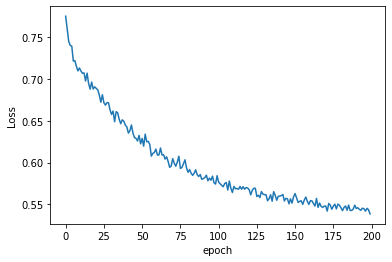

In [56]:
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain.float())
    aggregated_losses.append(single_loss)

    #if i % 25 == 1:
        #print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

#print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')



# Plot the loss over epocs
if "plot":
    plt.plot(range(epochs), aggregated_losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest.float())


y_val = (y_val > threshold).float()


print(confusion_matrix(ytest,y_val))
print(classification_report(ytest,y_val))
print(accuracy_score(ytest, y_val))

# Confusion matrix for black/white

In [58]:
df = data[totalnumber - testnumber:totalnumber]
black_data = df[df["race"]=="African-American"]
white_data = df[df["race"]=="Caucasian"]
Xcat_white, Xnum_white = dataprep(white_data, norm_type = "zscore")
Xcat_black, Xnum_black = dataprep(black_data, norm_type = "zscore")
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_val_white = (y_val_white > threshold).float()
y_val_black = model(Xcat_black, Xnum_black)
y_val_black = (y_val_black > threshold).float()

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
y_black = torch.tensor(black_data["two_year_recid"].values).flatten()

print("Confussion matrix for the white:")
conf_white = confusion_matrix( y_white, y_val_white)
print(conf_white)
print(conf_white / conf_white.astype(np.float).sum(axis=1))
print()
print("Confussion matrix for the black:")
conf_black = confusion_matrix( y_black, y_val_black)
print(conf_black)
print(conf_black / conf_black.astype(np.float).sum(axis=1))

Confussion matrix for the white:
[[216  81]
 [ 70 108]]
[[0.72727273 0.45505618]
 [0.23569024 0.60674157]]

Confussion matrix for the black:
[[256  93]
 [159 236]]
[[0.73352436 0.23544304]
 [0.45558739 0.59746835]]


* # Fede plots til fremtiden måske:


# Plots of the distribution of black and whites in each category of scoretext
sb.countplot(x = "score_text", data = black_data)
print(len(black_data[black_data["score_text"] == 0]))
print(len(black_data[black_data["score_text"] == 1]))
plt.show()
sb.countplot(x = "score_text", data = white_data)
print(len(white_data[white_data["score_text"] == 0]))
print(len(white_data[white_data["score_text"] == 1]))
plt.show()